In [16]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


$$x_n = rx_{n-1}(1-x_{n-1})$$

$$x_n = rsin(x_{n-1})$$

In [17]:
def evolutionX(r = 1, steps = 500):
    x = np.zeros(steps)
    x[0] = np.random.rand() # random initial value

    for n in range (1,steps):
        # 1st option
        x[n] = r * x[n-1] * (1 - x[n-1])
        # 2nd option
        # x[n] = r[j] * sin(x[n-1]) # don't forget to correct ylim
    
    # plot figure
    figure(figsize=(18, 4))
    plot(x)
    xlim((-5, 500))
    ylim(-0.1, 1)
    xlabel('Iterations, r =' + str(np.round(r,3)), fontsize=16)
    ylabel('Value of x, x0 =' + str(np.round(x[0],3)), fontsize=16)
    show()
    return None

# Task 1: Bifurcations

### Subtask 1: Implement the map, plot the evolution of x
Look on X evolution with constant r

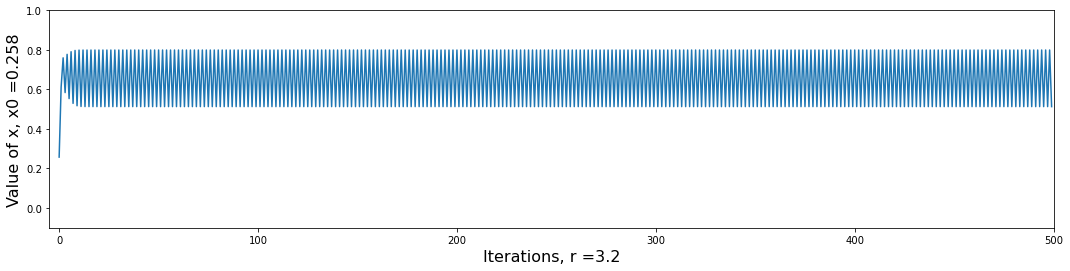

In [18]:
evolutionX(r = 3.2)

### Look on X evolution for different constant r

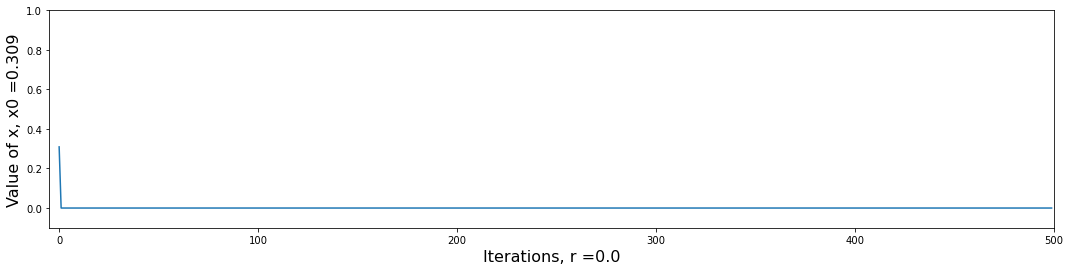

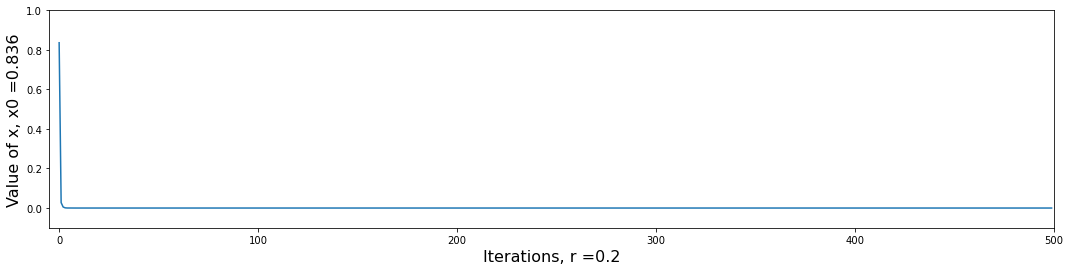

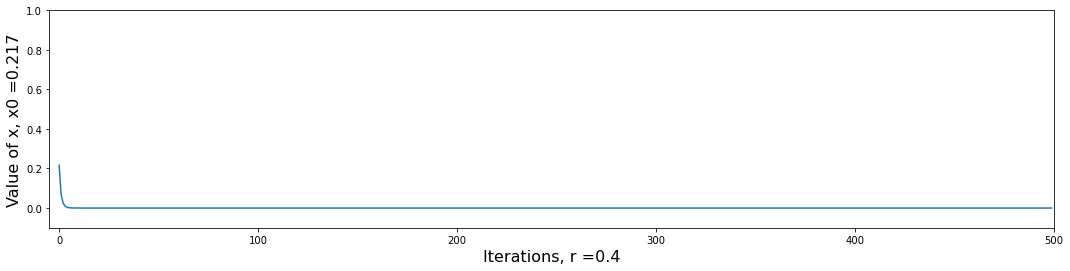

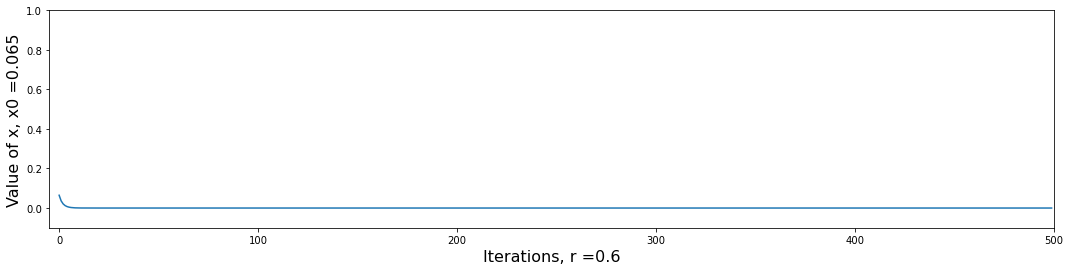

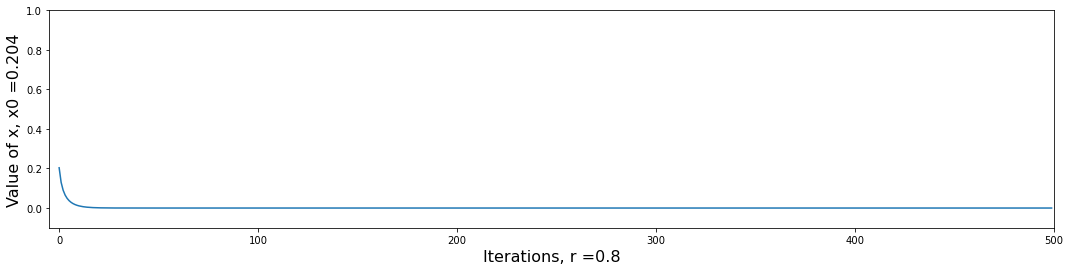

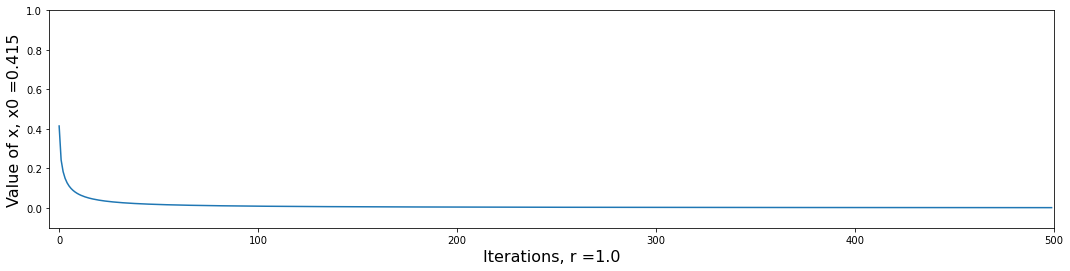

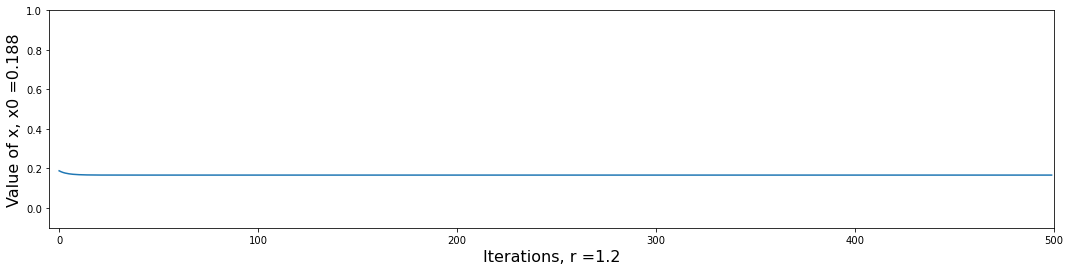

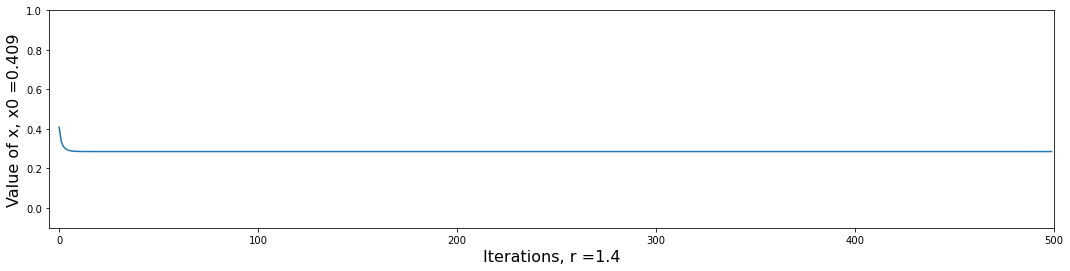

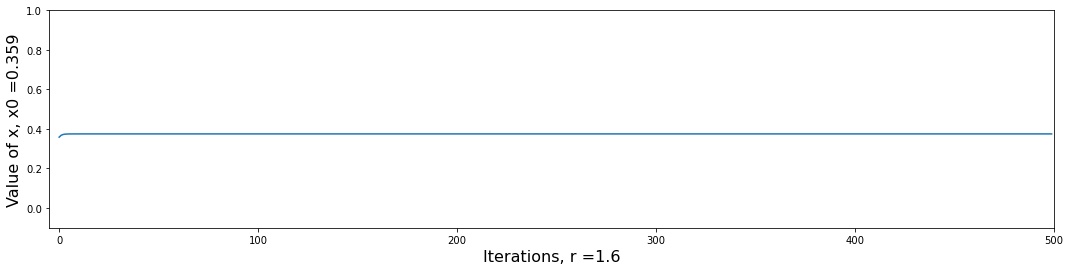

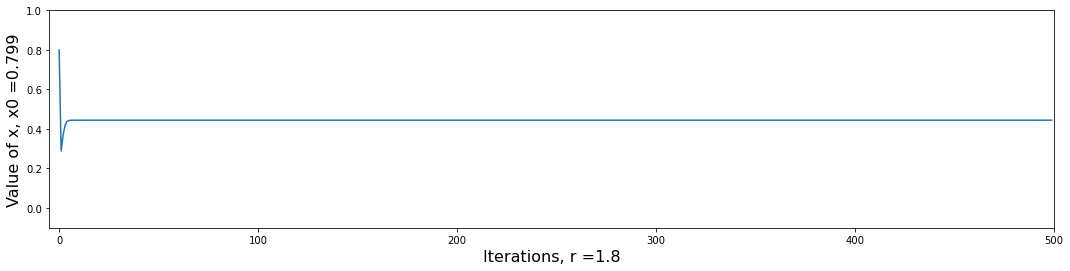

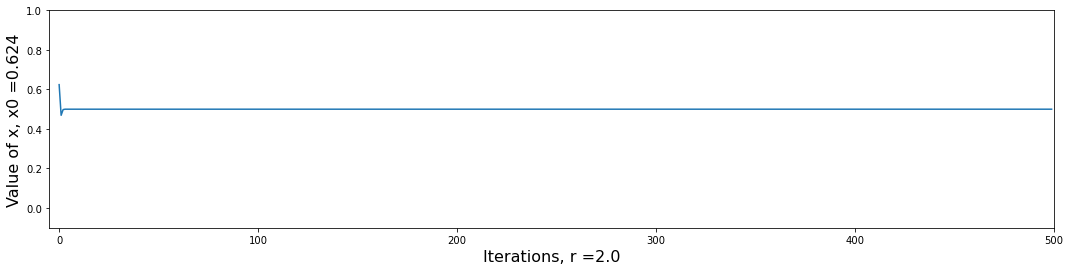

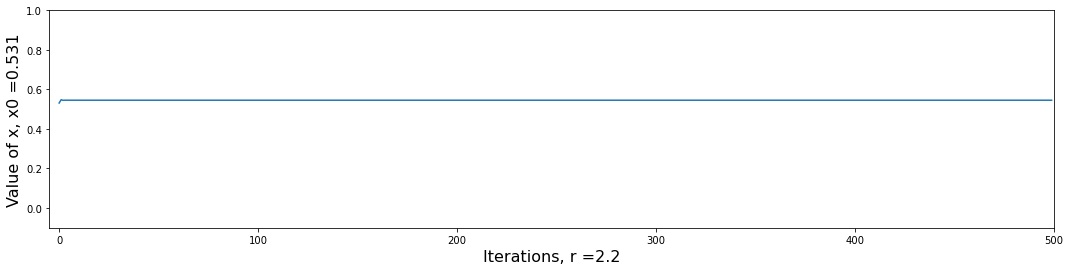

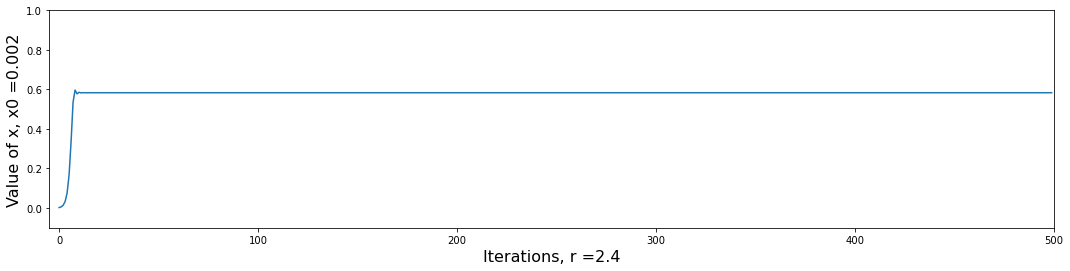

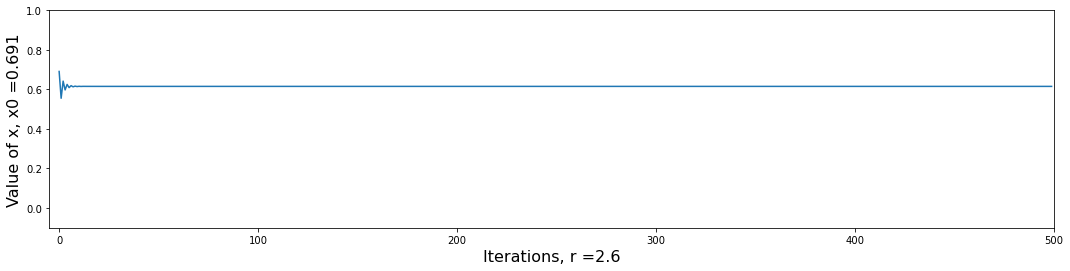

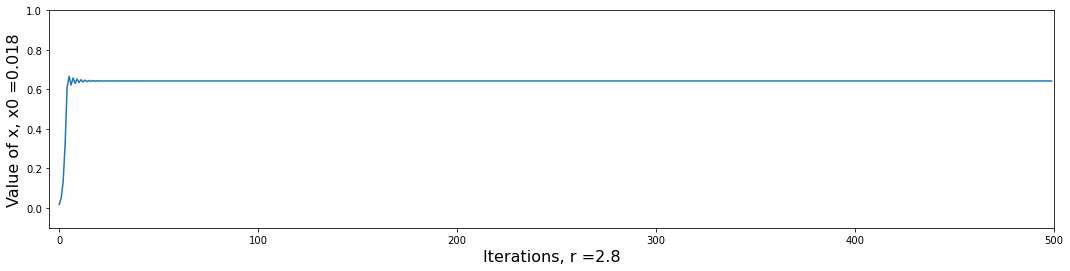

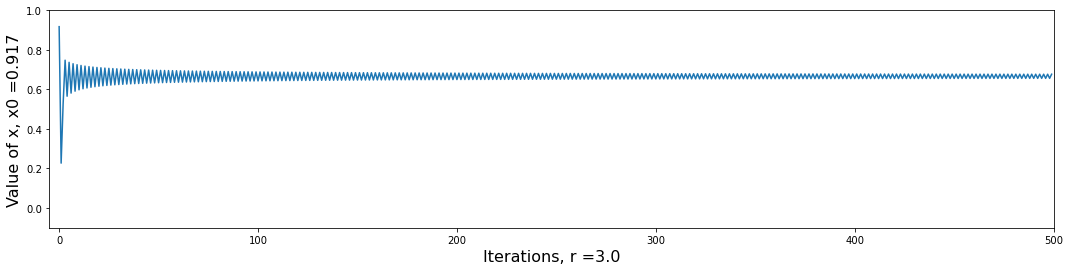

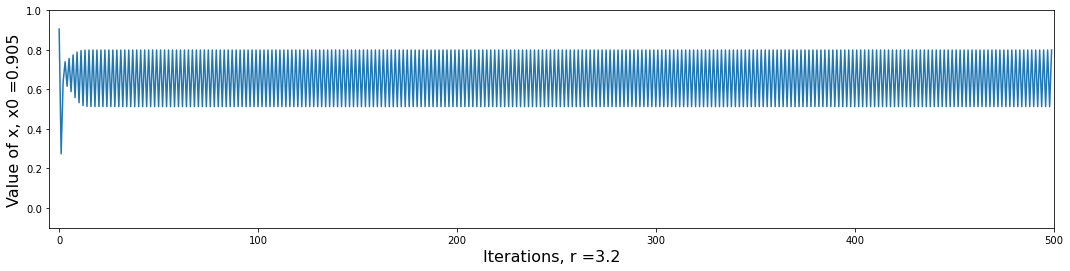

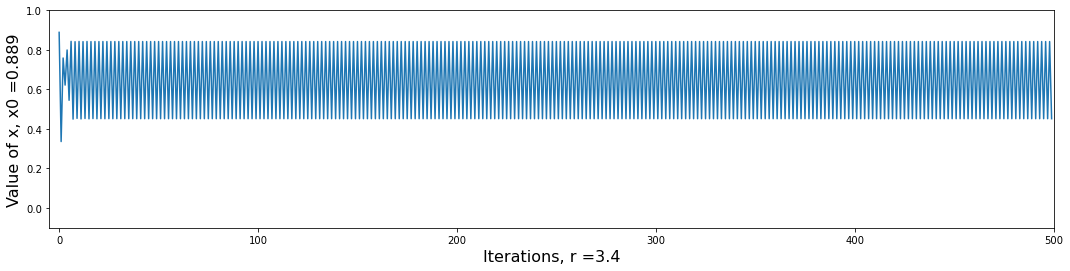

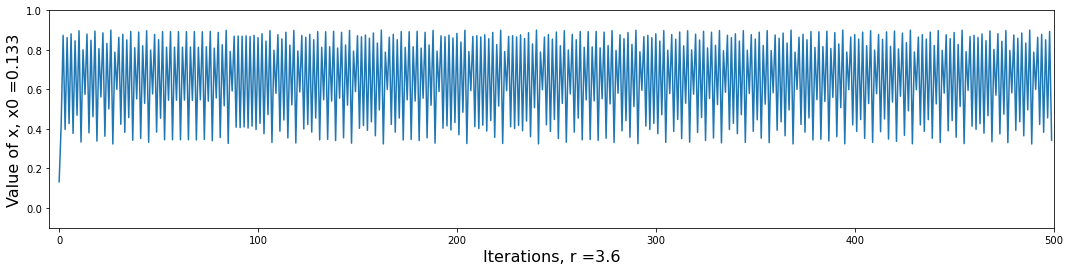

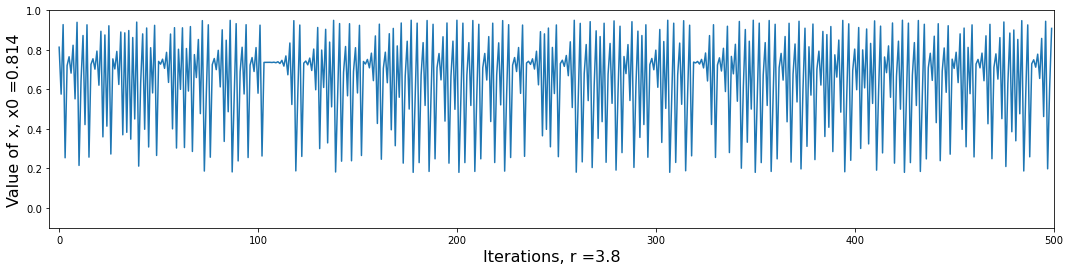

In [19]:
# see the evolution
for i in arange(0,4,0.2):
    evolutionX(i)

### Subtask 2: Create a linspace of r’s, for every r save the last “m” values of x after the first “n” values (can be m=200, x=200), play around with values

In [20]:
# m = 30 - the number of last values taken into account
# steps = 500 # the number of steps (in order to be stable)

def plotBifurcationMap(pointsX = 1000, minX = 0, maxX = 4, m = 10, steps = 100):
    r = np.linspace(minX,maxX,pointsX) # the range of r

    X = np.zeros([pointsX,m]) # array for scatterplot
    Y = np.zeros([pointsX,m]) # array for scatterplot

    x = np.zeros(steps)
    for j in arange(pointsX):
        x[0] = np.random.rand() # random initial size
        for n in range(1,steps):
            # choose 1 option
            x[n] = r[j] * x[n-1] * (1 - x[n-1])
            # x[n] = r[j] * sin(x[n-1])
            
        X[j] = (x[steps-m:steps]) # take into account the last m values
        Y[j] = r[j] # set r value for each x[inf] - for scatter plot
        
    plt.figure(figsize=(18, 10))
    xlim((minX, maxX))   # set the xlim to left, right
    #ylim(0, 1)     # set the xlim to left, right
    plt.ylabel('Values of static points', fontsize=20)
    plt.xlabel('Value of r', fontsize=20)
    plt.scatter(Y,X, c = 'b', s = 0.05)

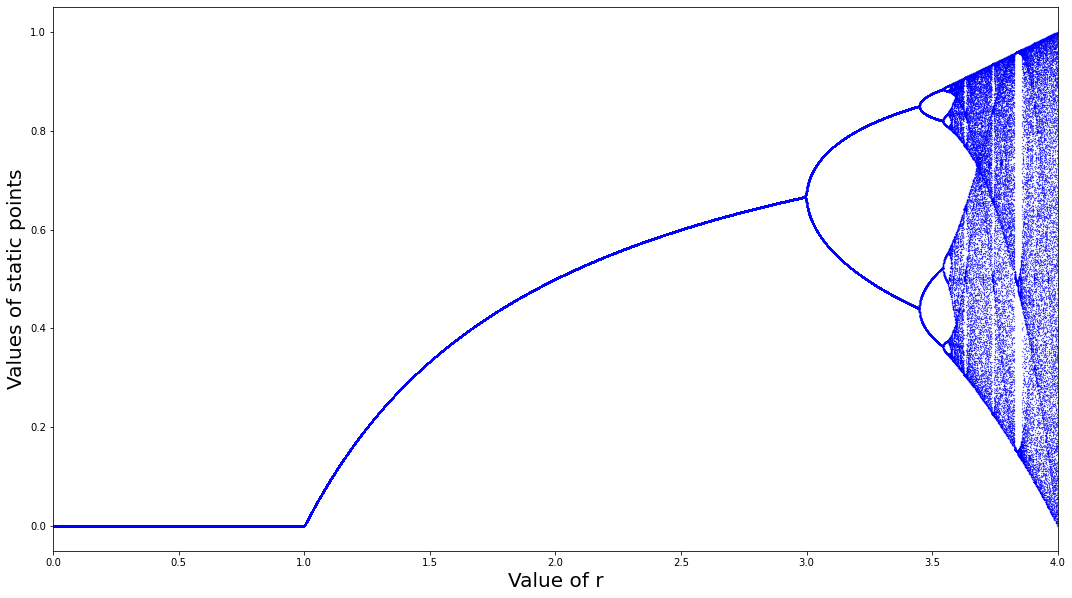

In [21]:
plotBifurcationMap(pointsX = 10000, minX = 0, maxX = 4, m = 40, steps = 500)

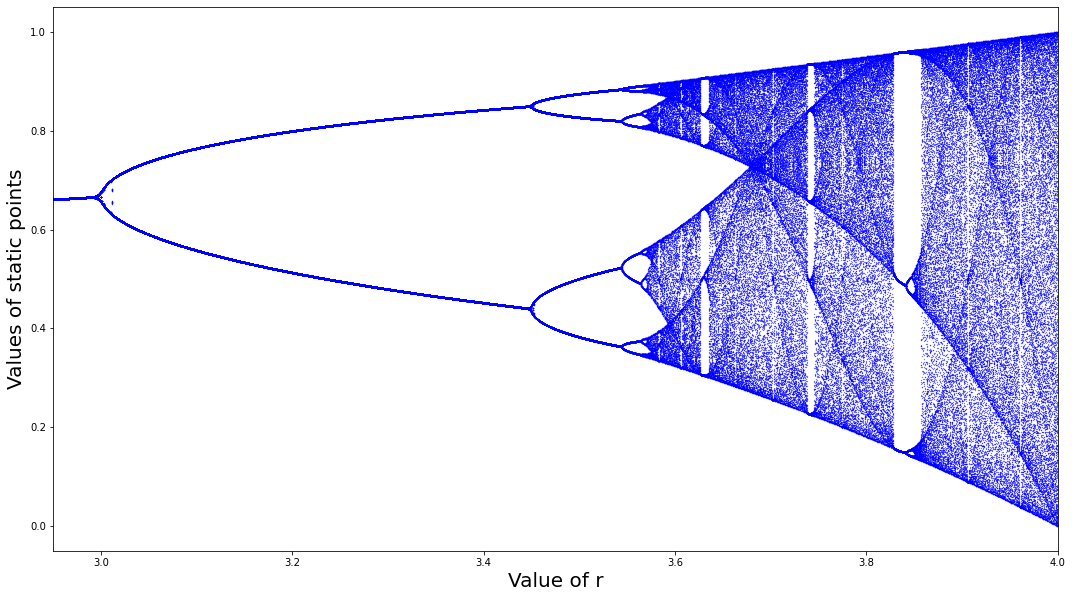

In [22]:
plotBifurcationMap(pointsX = 10000, minX = 2.95, maxX = 4, m = 40, steps = 500)

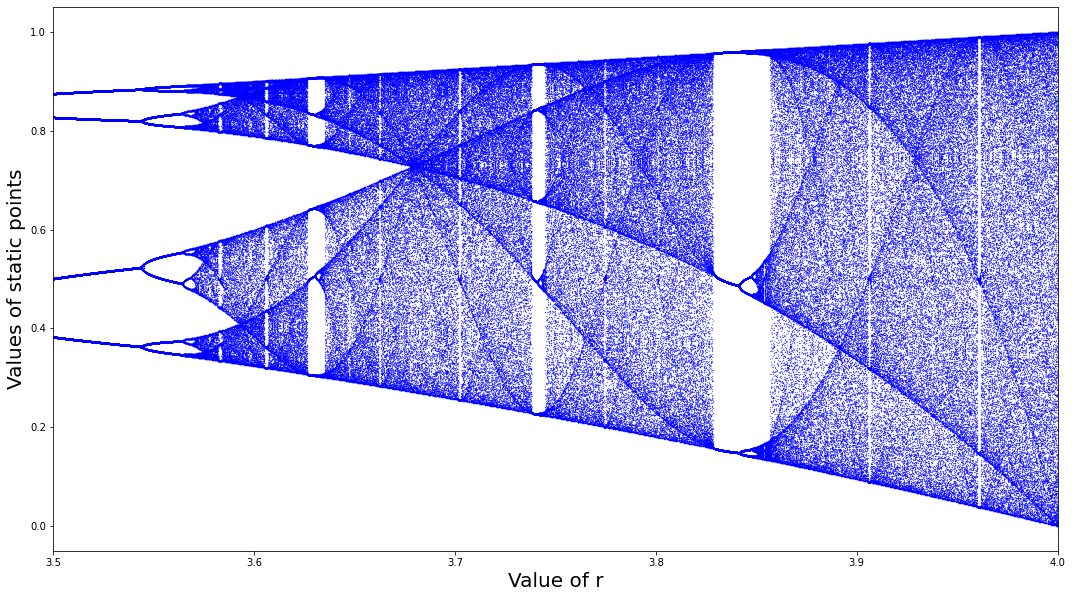

In [23]:
plotBifurcationMap(pointsX = 10000, minX = 3.5, maxX = 4, m = 40, steps = 500)

Populating the interactive namespace from numpy and matplotlib


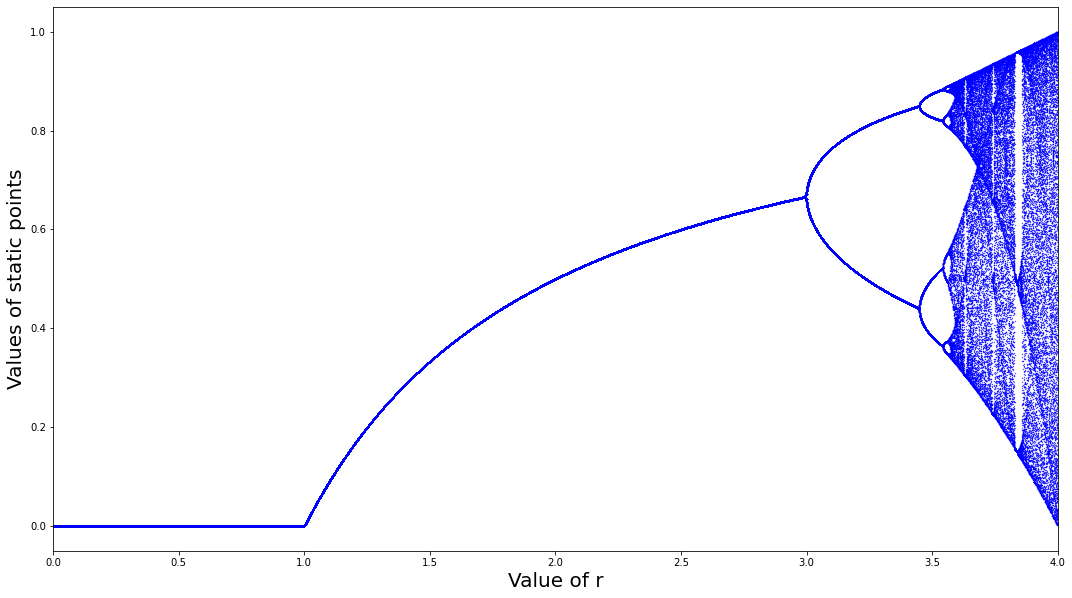

In [24]:
# jit bif map
%pylab inline
from numba import njit

# m = 30 # the number of last values taken into account
# steps = 500 # the number of steps (in order to be stable)

@njit(fastmath=True)
def func(pointsX = 1000, minX = 0, maxX = 4, m = 10, steps = 100):
    r = np.linspace(minX, maxX, pointsX) # the range of r

    X = np.zeros((pointsX, m)) # array for scatterplot
    Y = np.zeros((pointsX, m)) # array for scatterplot
    x = np.zeros(steps)
    
    for j in arange(pointsX):
        x[0] = np.random.rand() # random initial value
        for n in range(1,steps):
            # choose 1 option
            x[n] = r[j] * x[n-1] * (1 - x[n-1])
            # x[n] = r[j] * sin(x[n-1])
            
        X[j] = (x[steps-m:steps]) # take into account the last m values
        Y[j] = r[j] # set r value for each x[inf] - for scatter plot

    return X, Y

def plotBifurcationMap(pointsX = 10000, minX = 0, maxX = 4, m = 40, steps = 500):
    X, Y = func(pointsX = 10000, minX = 0, maxX = 4, m = 40, steps = 500)
    plt.figure(figsize=(18, 10))
    xlim((minX, maxX))   # set the xlim to left, right
    #ylim(0, 1)     # set the xlim to left, right
    plt.ylabel('Values of static points', fontsize=20)
    plt.xlabel('Value of r', fontsize=20)
    plt.scatter(Y,X, c = 'b', s = 0.1)
plotBifurcationMap(pointsX = 10000, minX = 0, maxX = 4, m = 40, steps = 500)

### Subtask 4: Parallel computation of bifurcation map

In [29]:
%%writefile bifurcation.py

import matplotlib.pyplot as plt

from mpi4py import MPI
import math
import numpy as np

def count(proc, points_X = 1000, n_proc = 10, minX = 0, maxX = 4, steps = 1000, m = 30):
    block_X = int(points_X / n_proc) # integer blocks of x axis
    remainder = points_X % n_proc # remainder for the last block

    add = 0 # addition of the last block
    if proc == n_proc-1: # if current process is last
        add = remainder # addition is equal to remainder
    
    # current x array (last with add =/= 0)
    arrayX = np.arange(block_X * proc, block_X * (proc+1) + add, 1)
    
    r = np.linspace((proc) * maxX / n_proc, (proc + 1) * maxX / n_proc, arrayX.size)
    # print(arrayX.size)
    
    X = np.zeros((block_X, m)) # array for scatterplot
    Y = np.zeros((block_X, m)) # array for scatterplot
    x = np.zeros(steps)
    
    for j in range(0, block_X, 1):
        x[0] = np.random.rand()
        
        for n in range(1,steps):
            x[n] = r[j] * x[n-1] * (1 - x[n-1])
            
        X[j] = (x[steps-m:steps]) # take into account the last m values
        Y[j] = r[j] # set r value for each x[inf] - for scatter plot
    return X, Y

comm = MPI.COMM_WORLD
n_proc = comm.Get_size() # processors
rank = comm.Get_rank() # current rank

if rank == 0:
    print('nprocs = ', n_proc)
    t0 = MPI.Wtime() # measure start time
  

X,Y = count(proc = rank, points_X = 2000, n_proc = n_proc, minX = 0, maxX = 4, steps = 500, m = 40)

X, Y = comm.gather(X, root=0), comm.gather(Y, root=0)

if rank == 0:
    fig = plt.scatter(Y,X, c = 'b', s = 0.1)
    totalTime = MPI.Wtime() - t0
    print(np.round((totalTime),4) * 1000, 'mSec')
    np.savez('subtask5/example_'+str(n_proc), totalTime = np.round((totalTime),4) * 1000)
    
    #plt.figure(figsize=(15, 9))
    #plt.xlim((0, 4))   # set the xlim to left, right
    #plt.ylim(0, 1)     # set the xlim to left, right
    plt.title('Bifurcation diagram', fontsize=14)
    plt.ylabel('Values of static points', fontsize=14)
    plt.xlabel('Value of r', fontsize=14)
    plt.savefig('bifurcation', dpi = 200)
    plt.close()

Overwriting bifurcation.py


nprocs =  10
290.8 mSec


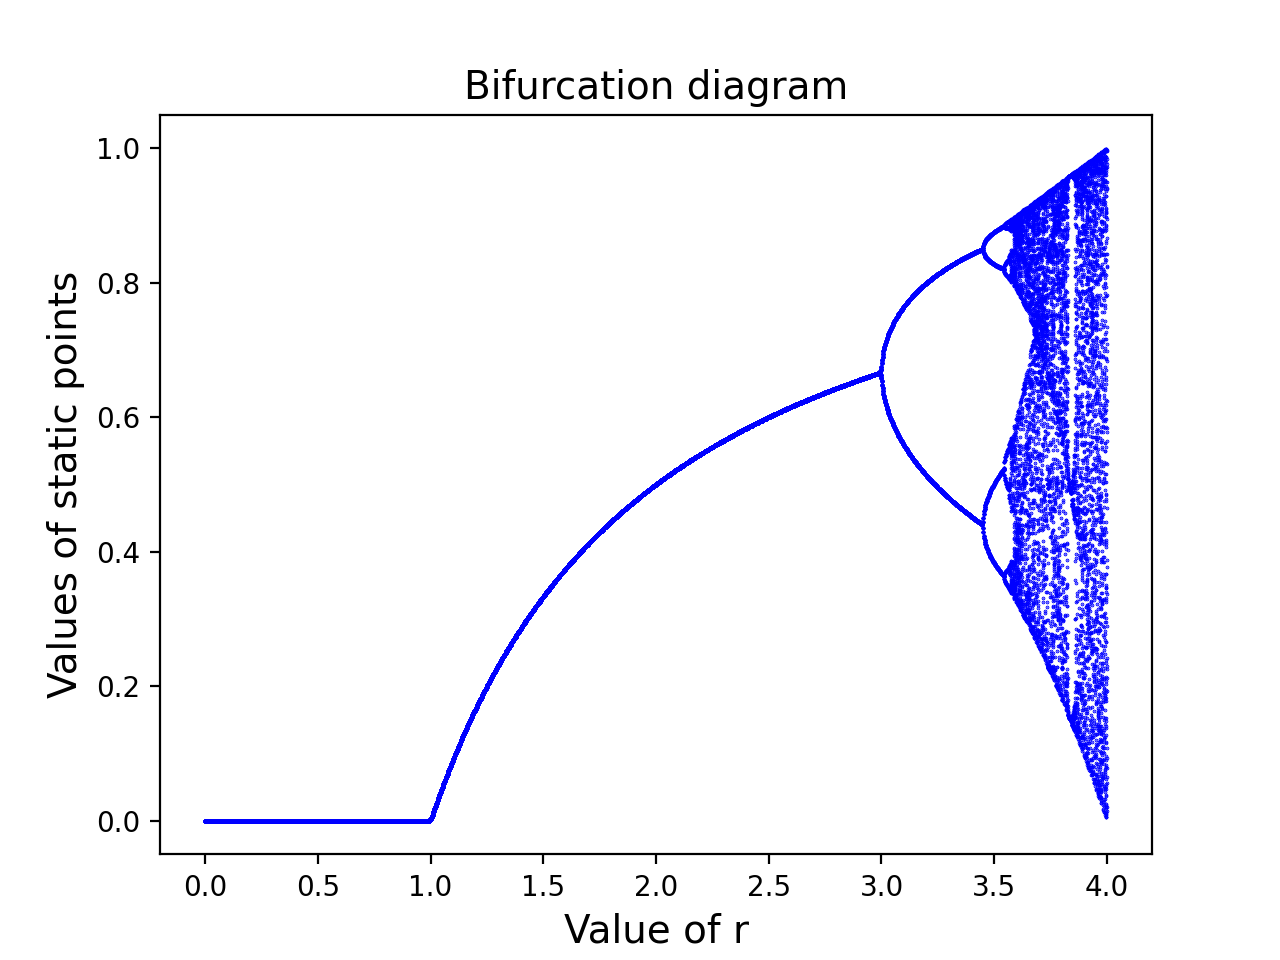

In [30]:
!mpiexec -n 10 python bifurcation.py
from IPython.display import Image
Image("bifurcation.png")

### Subtask 5: Plot speedup vs number of processors

In [27]:
!mpiexec -n 1 python bifurcation.py
!mpiexec -n 2 python bifurcation.py
!mpiexec -n 3 python bifurcation.py
!mpiexec -n 4 python bifurcation.py
!mpiexec -n 5 python bifurcation.py
!mpiexec -n 6 python bifurcation.py
!mpiexec -n 7 python bifurcation.py
!mpiexec -n 8 python bifurcation.py
!mpiexec -n 9 python bifurcation.py
!mpiexec -n 10 python bifurcation.py

nprocs =  1
784.4 mSec
nprocs =  2
429.4 mSec
nprocs =  3
337.7 mSec
nprocs =  4
362.3 mSec
nprocs =  5
392.7 mSec
nprocs =  6
283.5 mSec
nprocs =  7
363.09999999999997 mSec
nprocs =  8
372.40000000000003 mSec
nprocs =  9
349.6 mSec
nprocs =  10
320.2 mSec


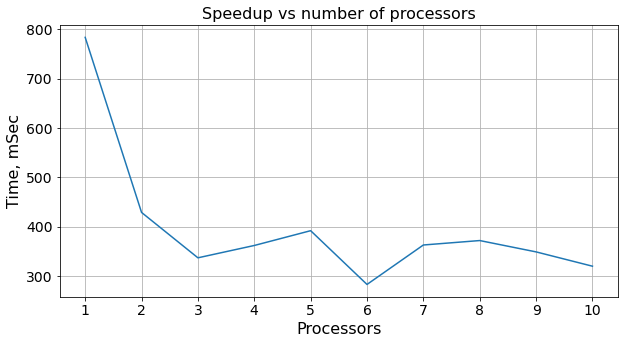

In [28]:
import numpy as np
import matplotlib.pyplot as plt

a = []
for i in range(1, 11, 1):
    ex = np.load('subtask5/example_'+str(i)+'.npz')
    a.append(int(ex['totalTime']))
    
plt.figure(figsize=(10, 5))
plt.title('Speedup vs number of processors', fontsize=16)
plt.ylabel('Time, mSec', fontsize=16)
plt.xlabel('Processors', fontsize=16)
plt.xticks(np.arange(0, 11), np.arange(1, 12), fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.plot(a)